### Step-by-Step Explanation:

1. **Import Libraries:**
   - Libraries like `os`, `numpy`, `tensorflow`, and related modules are imported. These are common libraries for data manipulation, numerical operations, and deep learning.

2. **Define Paths and Load Data:**
   - Set the path to the dataset directory.
   - Load image and mask file paths into lists.

3. **Define Image and Mask Processing Function:**
   - Function `process_images_masks` processes images and masks from directories. It reads images and masks, resizes them, and collects them into numpy arrays.

4. **Define Data Augmentation Generator Function:**
   - Function `create_augmentation_datagen` creates an image data generator for data augmentation purposes using Keras' `ImageDataGenerator`.

5. **Generate Augmented Data:**
   - Augment data using the defined data augmentation generator.

6. **Define UNet Model Architecture:**
   - Define functions for creating the convolutional blocks and the UNet model itself.

7. **Create UNet Model Instance:**
   - Create an instance of the UNet model using the defined architecture.

8. **Define Training Generator Function:**
   - Define a function `train_generator_func` that yields batches of images and masks indefinitely.

9. **Create Final Training Generator:**
   - Create the final training generator using the defined function and the augmented image and mask generators.

10. **Train the Model:**
    - Train the UNet model using the final training generator. Adjust parameters like steps per epoch and number of epochs as needed.

11. **Save Trained Model:**
    - Save the trained model to a file.

12. **Optional: Plot Training History:**
    - Plot training history (loss and accuracy) for analysis.

**Code**

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.transform import resize
from skimage.io import imread, imshow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam

2024-05-12 13:12:51.316635: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 13:12:51.316736: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 13:12:51.482240: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os

path = '/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset'

files = os.listdir(path)
files

['Tile 7',
 'Tile 8',
 'Tile 2',
 'Tile 5',
 'Tile 1',
 'Tile 3',
 'classes.json',
 'Tile 6',
 'Tile 4']

In [3]:
def process_images_masks(tiles_dir, image_suffix, mask_suffix, target_size=(256, 256)):
    all_images = []
    all_masks = []
    
    # Loop through all the tile directories
    for tile in sorted(os.listdir(tiles_dir)):
        current_tile_dir = os.path.join(tiles_dir, tile)
        image_dir = os.path.join(current_tile_dir, 'images')  # Assuming images are in a subfolder named 'images'
        mask_dir = os.path.join(current_tile_dir, 'masks')  # Assuming masks are in a subfolder named 'masks'
        
        # Collect images
        for image_file in sorted(os.listdir(image_dir)):
            if image_file.endswith(image_suffix):
                image_path = os.path.join(image_dir, image_file)
                image = imread(image_path)
                image = resize(image, target_size, mode='constant', preserve_range=True)
                all_images.append(image)
                
        # Collect masks
        for mask_file in sorted(os.listdir(mask_dir)):
            if mask_file.endswith(mask_suffix):
                mask_path = os.path.join(mask_dir, mask_file)
                mask = imread(mask_path, as_gray=True)
                mask = resize(mask, target_size, mode='constant', preserve_range=True)
                mask = np.expand_dims(mask, axis=-1)  # Add an extra dimension for the channel
                all_masks.append(mask)
    
    # Convert lists to numpy arrays and make sure masks are boolean
    all_images = np.array(all_images, dtype=np.uint8)
    all_masks = np.array(all_masks, dtype=np.bool_)  # Change from np.bool to np.bool_ here

    # Normalize images
    all_images = all_images / 255.0

    return all_images, all_masks

In [4]:
# Create a data generator for augmentation
def create_augmentation_datagen():
    return ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

In [5]:
tiles_dir = '/kaggle/input/semantic-segmentation-dataset/Semantic segmentation dataset/Tiles'

In [6]:
# Process images and masks from all directories
all_images, all_masks = process_images_masks(tiles_dir, image_suffix='.jpg', mask_suffix='.png')

In [7]:
def create_augmentation_datagen():
    return ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

In [8]:
datagen = create_augmentation_datagen()

In [9]:
seed = 1
image_generator = datagen.flow(all_images, seed=seed)
mask_generator = datagen.flow(all_masks, seed=seed)

In [10]:
train_generator = zip(image_generator, mask_generator)

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam

def conv_block(input_tensor, num_filters):
    tensor = Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    tensor = tf.keras.layers.Activation('relu')(tensor)
    tensor = Conv2D(num_filters, (3, 3), padding='same')(tensor)
    tensor = tf.keras.layers.Activation('relu')(tensor)
    return tensor

def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Downscaling (contracting path)
    conv1 = conv_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(pool3, 512)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = conv_block(pool4, 1024)

    # Upscaling (expanding path)
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=-1)
    conv6 = conv_block(up6, 512)
    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    conv7 = conv_block(up7, 256)
    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    conv8 = conv_block(up8, 128)
    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    conv9 = conv_block(up9, 64)

    # Final convolution
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create the U-Net model instance
unet = unet_model()


In [12]:
unet = unet_model(input_size=(256, 256, 3))

In [13]:
def train_generator_func(image_generator, mask_generator):
    while True:
        # Get next batch of images and masks
        imgs = next(image_generator)
        masks = next(mask_generator)
        yield (imgs, masks)

# Create the generator using the function
final_train_generator = train_generator_func(image_generator, mask_generator)

# Fit the model using the final_train_generator
history = unet.fit(
    final_train_generator,
    steps_per_epoch=200,  # Adjust this to your dataset size divided by the batch size
    epochs=10,  # Number of epochs to train for
    verbose=1
)


Epoch 1/10


2024-05-12 13:14:54.963840: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng36{k2=3,k3=0} for conv (f32[32,128,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,384,128,128]{3,2,1,0}, f32[128,384,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-05-12 13:14:55.006743: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.043035645s
Trying algorithm eng36{k2=3,k3=0} for conv (f32[32,128,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,384,128,128]{3,2,1,0}, f32[128,384,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_al

  2/200 ━━━━━━━━━━━━━━━━━━━━ 4:38 1s/step - accuracy: 0.9966 - loss: 0.6776      

2024-05-12 13:21:00.783223: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,192,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,192,256,256]{3,2,1,0}, f32[8,64,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-05-12 13:21:02.774699: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.991586565s
Trying algorithm eng0{} for conv (f32[64,192,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,192,256,256]{3,2,1,0}, f32[8,64,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-05-12 13:21:06.222729: E external/

200/200 ━━━━━━━━━━━━━━━━━━━━ 679s 2s/step - accuracy: 0.9994 - loss: 0.1170
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.9996 - loss: 0.0023
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.9996 - loss: 0.0020
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.9996 - loss: 0.0020
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.9995 - loss: 0.0024
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.9996 - loss: 0.0018
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.9996 - loss: 0.0017
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.9996 - loss: 0.0015
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.9996 - loss: 0.0014
Epoch 10/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.9996 - loss: 0.0012


In [14]:
# Save the trained model
unet.save('unet_model.h5')

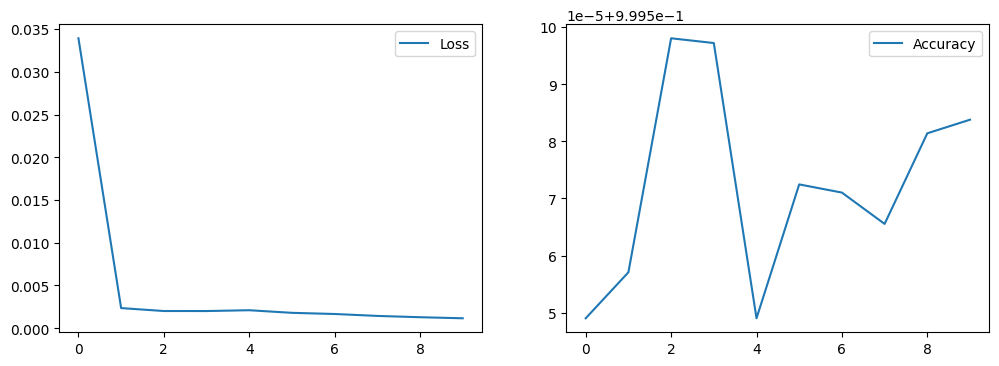

In [15]:
# Optional: Plot training history for analysis
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.legend()
plt.show()